In [1]:
import pickle
import numpy as np
import os
import os.path as pathlib
from stats_fun import get_statistic_info, cal_ci95
import matplotlib.pyplot as plt
base_path = '/mnt/eye_team/kangdang/mmc_project_2023_submission/exp_records/fusion_exps/random_mi_single_variable/'

def get_score_and_gt_helper(base_path, method_id, feature_id, fusion_type='fusion'):
    input_dir = pathlib.join(base_path, method_id)
    val_pred_list = list()
    val_gt_list = list()
    test_pred_list = list()
    test_gt_list = list()
    for mice_id in range(20):
        curr_folder = pathlib.join(input_dir, 'mice_imputation_' + str(mice_id+ 1), fusion_type)
        train_score = pd.read_csv(pathlib.join(curr_folder, "feat_[" + str(feature_id) + "]_train_pred_result.csv"))
        val_score = pd.read_csv(pathlib.join(curr_folder, "feat_[" + str(feature_id) + "]_val_pred_result.csv"))
        pred = list(train_score['pred'])
        pred.extend(list(val_score['pred']))
        gt = list(train_score['gt'])
        gt.extend(list(val_score['gt']))
        pred = np.array(pred)
        gt = np.array(gt)
        val_pred_list.append(pred)
        val_gt_list.append(gt)
        test_pred_list.append(pred)
        test_gt_list.append(gt)

    assert((val_gt_list[0] == val_gt_list[1]).all())
    assert((test_gt_list[0] == test_gt_list[1]).all())
    val_gt_list = val_gt_list[0]
    test_gt_list = test_gt_list[0]
    val_pred_list = np.mean(np.array(val_pred_list), axis = 0)
    test_pred_list = np.mean(np.array(test_pred_list), axis = 0)
    return val_gt_list, test_gt_list, val_pred_list, test_pred_list


# image only result
test_result_pickle = pickle.load(open('/mnt/eye_team/kangdang/mmc_project_2023_submission/exp_records/image_only_exps/top_checkpoint_ensemble_train_result.pickle', 'rb'))
test_pred_set = test_result_pickle['pred_set']
test_gt_set = test_result_pickle['gt_set']
test_result_pickle = pickle.load(open('/mnt/eye_team/kangdang/mmc_project_2023_submission/exp_records/image_only_exps/top_checkpoint_ensemble_val_result.pickle', 'rb'))
test_pred_set = np.concatenate((test_pred_set, test_result_pickle['pred_set']), axis = 0)
test_gt_set = np.concatenate((test_gt_set, test_result_pickle['gt_set']), axis = 0)
print(test_pred_set.shape)

auc95_dl, fpr_dl, tpr_dl, auc_dl = get_statistic_info(test_gt_set, test_pred_set)
print(auc95_dl)
auc95, rec, sep, sep_90, global_auc, global_rec, global_sep, global_sep_90, _, _ = cal_ci95(test_gt_set, test_pred_set, 0.8)
print(rec)
print(global_rec)
print(sep)
print(global_sep)

(29081,)
[0.8351297902514454, 0.8436207089695522]
[0.7690968864823051, 0.7789920476167244]
0.7740028110308729
[0.7440123310410244, 0.7589755864049784]
0.7511837121212122


In [2]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import sklearn.metrics as sklm
import os.path as pathlib
import sklearn.metrics as metrics

def get_score_and_gt(base_path, feature_id, fusion_type='fusion',  method_id_list = ['method_lr_basic', 'method_lda_basic','method_gbc_basic', 'method_rf_basic',  'method_lsvm_basic',  'method_rbfsvm_basic']):
    val_auc_list = []
    for method_id in method_id_list:
        val_gt_list, _,val_pred_list, _ = get_score_and_gt_helper(base_path, method_id, feature_id, fusion_type)
        fpr, tpr, threshold = metrics.roc_curve(val_gt_list, val_pred_list)
        auc = metrics.auc(fpr, tpr)
        val_auc_list.append(auc)
    
    best_val_idx = np.argmax(val_auc_list)
    best_method_id = np.array(method_id_list)[best_val_idx]
    val_gt_list, test_gt_list, val_pred_list, test_pred_list = get_score_and_gt_helper(base_path, best_method_id, feature_id, fusion_type)
    return best_method_id, val_gt_list, test_gt_list, val_pred_list, test_pred_list

def get_statistic_info(test_gt_list, test_pred_list):
    auc95, rec, sep, sep_90, global_auc, global_rec, global_sep, global_sep_90, _, _ = cal_ci95(test_gt_list, test_pred_list, 0.8)
    fpr, tpr, threshold = metrics.roc_curve(test_gt_list, test_pred_list)
    auc = metrics.auc(fpr, tpr)
    return auc95, fpr, tpr, auc

def get_indicator_all_results():
    indicator_id_list = ["'1'", "'2'", "'3'", "'4'", "'5'", "'6'", "'7'", "'8'", "'9'", "'10'", "'11'", "'12'"]
    indicator_name_list = ['Gender', 'Age', 'Diastolic Bp', 'Systolic Bp',  'Heart Rate', 'BMI', 'Course of Diabetes (Months)', 'Hypertension', 'Hyperlipidemia', 'Cardiovascular Disease', 'Classification of smoker', 'Classification of drinker']
    result_dict = dict()
    for indicator_id, indicator_name in zip(indicator_id_list, indicator_name_list):
        print(indicator_name)
        best_method_id, val_gt_list, test_gt_list, val_pred_list, test_pred_list = get_score_and_gt(base_path, indicator_id, method_id_list = ['method_lr_basic'])
        auc95, fpr, tpr, auc = get_statistic_info(test_gt_list, test_pred_list)
        result_dict[indicator_name] = [best_method_id, auc95, fpr, tpr, auc]
    return result_dict

result_dict = get_indicator_all_results()
sort_dict = dict()
for key, value in result_dict.items():
    sort_dict[key] = -value[-1]
sort_keys = sorted(sort_dict, key=sort_dict.get)

Gender
Age
Diastolic Bp
Systolic Bp
Heart Rate
BMI
Course of Diabetes (Months)
Hypertension
Hyperlipidemia
Cardiovascular Disease
Classification of smoker
Classification of drinker


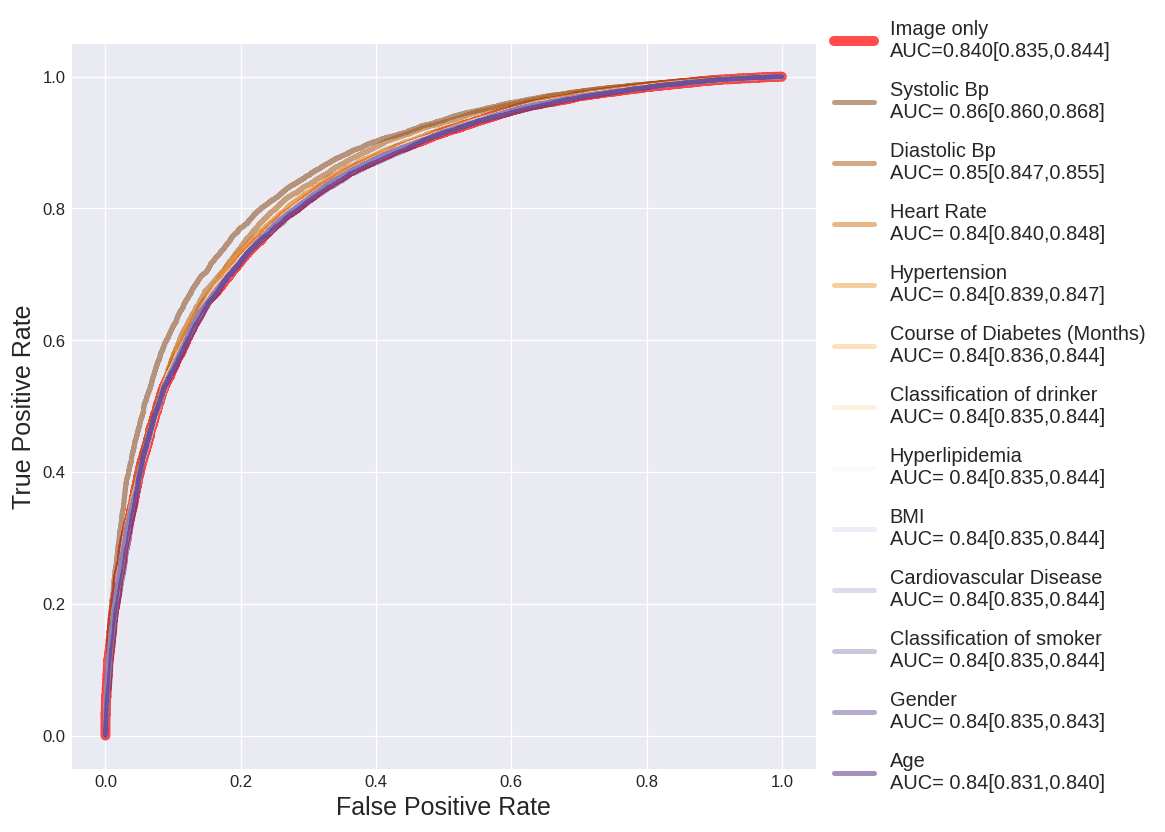

In [3]:
import matplotlib as mpl
my_dpi=120
plt.figure(figsize=(960/my_dpi, 960/my_dpi), dpi=my_dpi)
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set3')
cmap = mpl.cm.get_cmap('PuOr')
plt.plot(fpr_dl, tpr_dl, marker='', color='red', linewidth=6, alpha=0.7, label='Image only\nAUC='+ "{:.3f}".format(auc_dl)+ '[{:.3f}'.format(auc95_dl[0]) + ',{:.3f}'.format(auc95_dl[1]) + ']')
prespace = [12, 3, 0, 3, 3, 0, 0, 3, 6, 3, 6, 0]
for idx, key in enumerate(sort_keys):
    value = result_dict[key]
    fpr = value[2]
    tpr = value[3]
    label = key + '\nAUC= ' + "{:.2f}".format(value[4]) + '[{:.3f}'.format(value[1][0]) + ',{:.3f}'.format(value[1][1]) + ']'
    color = cmap((idx/len(sort_keys)))
    plt.plot(fpr,tpr, marker='', color=color, linewidth=3, alpha=0.5, label=label)
plt.legend(prop={'size': 14})

ax=plt.gca()
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),labelspacing=1, prop={'size': 12})